In [2]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import os

In [3]:
data_path = '../../CubiCasa5k/data/cubicasa5k/'
with open(data_path + 'test.txt') as f: files = [f'{data_path}{n[1:-1]}F1_original.png'  for n in f.readlines()]
print('\n'.join(f'{i}, {f}' for i,f in enumerate(files[:10])))

0, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/1191/F1_original.png
1, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2536/F1_original.png
2, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2530/F1_original.png
3, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2504/F1_original.png
4, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2207/F1_original.png
5, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/22/F1_original.png
6, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2090/F1_original.png
7, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2085/F1_original.png
8, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2014/F1_original.png
9, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2011/F1_original.png


desenhado.png


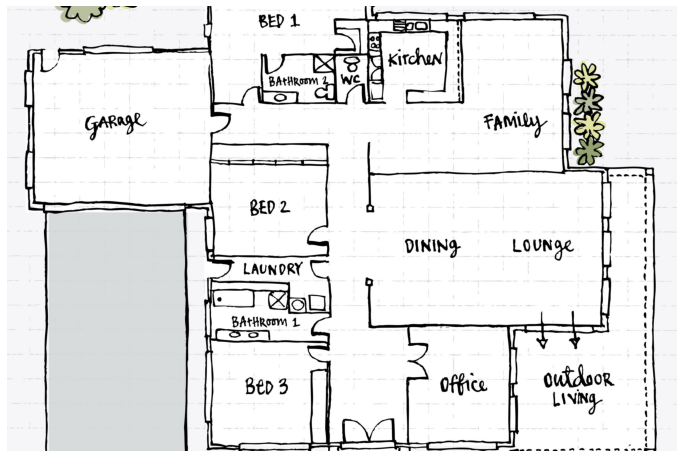

In [4]:
image_name = 'desenhado.png'
path = f'./qualitative/r2v/{image_name.split("/")[-1].split(".")[0]}/'

# image_name = files[0]
# path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
print(image_name)
os.makedirs(path, exist_ok=True)

original = cv2.imread(image_name)
try:
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
except:
    original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(12,12))
plt.axis('off')

plt.imshow(original)
plt.savefig(path + 'original.png', bbox_inches='tight', pad_inches=0)

# from segmentation import predict
# rooms_pred, icons_pred, heatmaps = predict(original)

In [6]:
from raster_to_vector import recognize
from recognition import *
import time

verbose = True

prediction = recognize(image_name, verbose)

walls, doors, windows = prediction['walls'], prediction['doors'], prediction['windows']

walls = attach_openings(walls, doors + windows, verbose)

all_structural = walls
walls = normalize_wall_points(walls, all_structural, 5)

walls = classify_wall_elements(walls, original, verbose)
# symbols = classify_symbols(prediction['symbols'], original, verbose)
symbols = prediction['symbols']

res = {'walls': walls, 'symbols': symbols}

100%|██████████| 9/9 [00:00<00:00, 58.34it/s]


In [7]:
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [8]:
def draw_poly(img, points, colors, thickness):
    img = img.copy()
    for i in range(len(points)):
        p, q = points[i], points[(i+1)%len(points)]
        img = cv2.line(img, p, q, colors[i%len(colors)], thickness)
    return img


In [11]:
selected = [0, 1, 2, 3, 5, 6, 9] # 0, windows, doors, closets, toilets, sinks, bathtubs

cpool = np.array(['#ffffff', '#8dd3c7', '#b15928', '#fdb462', '#ffff99', '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969', '#577a4d'])
cpool = list(cpool[selected])
cmap1 = matplotlib.colors.ListedColormap(cpool, 'selected_icons')
cm.register_cmap(cmap=cmap1)

negation = list(set(range(len(icon_classes))) - set(selected))
to = list(range(0, len(selected)))

selected_icons = list(np.array(icon_classes)[selected])

/tmp/ipykernel_2062/738782739.py:6: UserWarning: Trying to register the cmap 'selected_icons' which already exists.
  cm.register_cmap(cmap=cmap1)


In [12]:
def put_text(img, text, pos, size=1, color=(255, 255, 255, 255)):
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, (0, 0, 0, 255), thickness=4, lineType=cv2.LINE_AA
    )
    img = cv2.putText(
        img, text, pos,
        cv2.FONT_HERSHEY_SIMPLEX, size, color, thickness=2, lineType=cv2.LINE_AA
    )
    return img

def to_rgba(hex):
    hex = hex[1:]
    return tuple(tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))) + (255, )

symbols = ['No Icon', 'window', 'door', 'closet', 'toilet', 'sink', 'bathtub']
symbol_colors = [to_rgba(c) for c in cpool]
colors = {'walls': [(66, 66, 66, 255), (91, 93, 91, 255)], 'railings': [(203, 153, 20, 255), (255, 180, 40, 255)]}

door_color = (177, 89, 40, 255)
window_color = (141, 211, 199, 255)

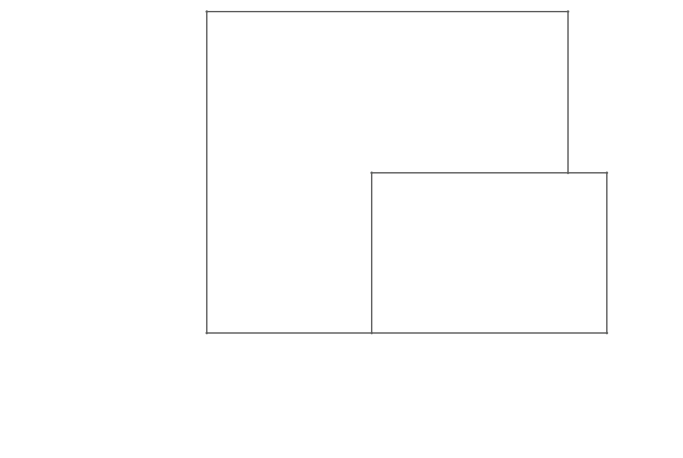

In [13]:
reconstr = np.copy(original)
reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)

for t in ['walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], 3)

    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'vector.png', bbox_inches='tight', pad_inches=0)

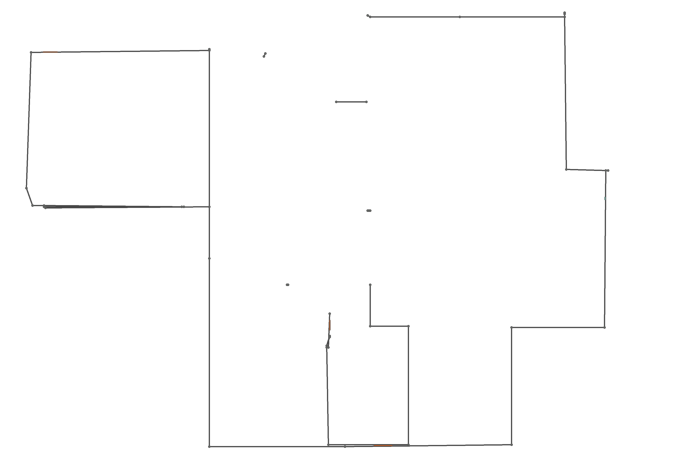

In [12]:
# reconstr = np.copy(original)
reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], 3)

    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), window_color, 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), door_color, 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'attached.png', bbox_inches='tight', pad_inches=0)

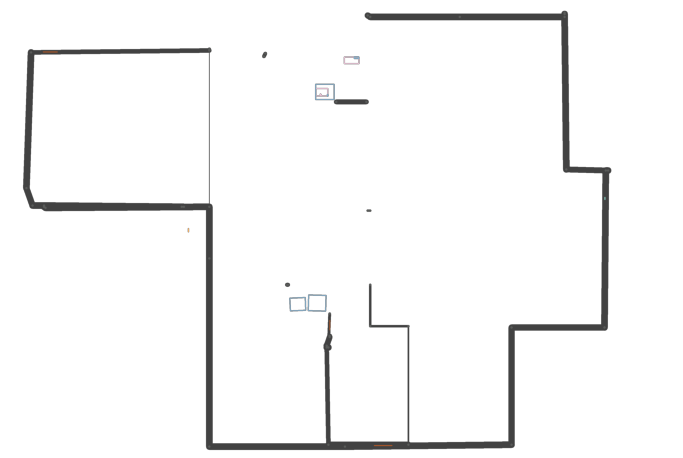

In [13]:
# reconstr = np.copy(original)
reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], el["width"])

# alpha = 0.5
# reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), window_color, 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), door_color, 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'withicons.png', bbox_inches='tight', pad_inches=0)

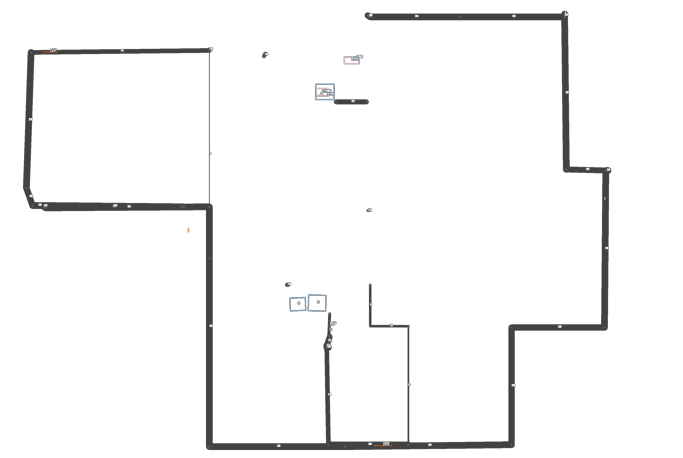

In [14]:
# reconstr = np.copy(original)
reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], el["width"])

# alpha = 0.5
# reconstr = cv2.addWeighted(reconstr, alpha, reconstr, 1 - alpha, 0)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), window_color, 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), door_color, 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)

for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

for wall in res['walls']:
    centroid = np.intp(np.mean(wall['points'], axis=0))
    reconstr = put_text(reconstr, str(wall['width']), centroid, 0.4)
    if 'elements' in wall:
        for el in wall['elements']:
            if el['type'] == 'door':
                centroid = np.intp(np.mean(el['points'], axis=0))
                orientation = el['orientation'][-2:]
                if 'opposite' in el['orientation']: orientation = 'o' + orientation
                reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

for symbol in res['symbols']:
    if symbol['type'] in ('toilet', 'sink'):
        centroid = np.intp(np.mean(symbol['points'], axis=0))
        reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'allsemantics.png', bbox_inches='tight', pad_inches=0)

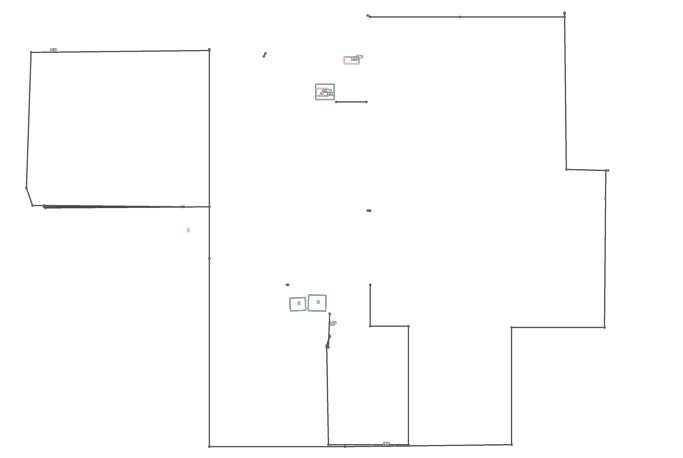

In [15]:
# reconstr = np.copy(original)
reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], 3)

# alpha = 0.3
# reconstr = cv2.addWeighted(reconstr, alpha, original, 0.1, 0)

for t in ['railings', 'walls']:
    for el in res[t]:
        s, e = el['points']
        reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
        reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

for wall in res['walls']:
    if 'elements' in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), window_color, 3)
            else:
                # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)
                reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55), (15,157,88), (66,133,244), (186,85,211)), 1)

for symbol in res['symbols']:
    reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 3)

for wall in res['walls']:
    centroid = np.intp(np.mean(wall['points'], axis=0))
    if 'elements' in wall:
        for el in wall['elements']:
            if el['type'] == 'door':
                centroid = np.intp(np.mean(el['points'], axis=0))
                orientation = el['orientation'][-2:]
                if 'opposite' in el['orientation']: orientation = 'o' + orientation
                reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7)

for symbol in res['symbols']:
    if symbol['type'] in ('toilet', 'sink'):
        centroid = np.intp(np.mean(symbol['points'], axis=0))
        reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5)

plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(reconstr)
plt.savefig(path + 'no_width.png', bbox_inches='tight', pad_inches=0)

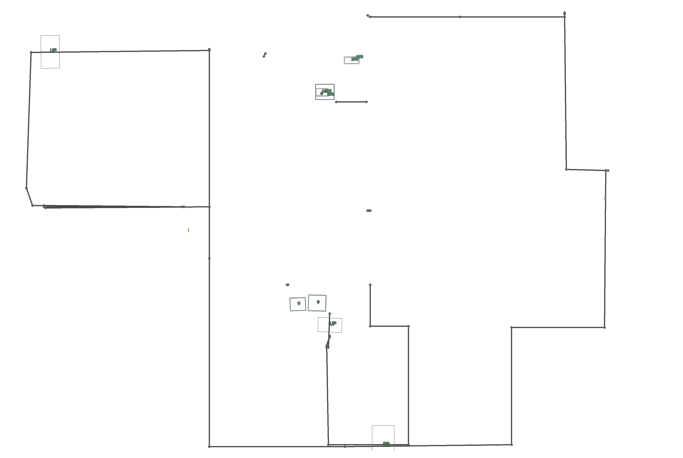

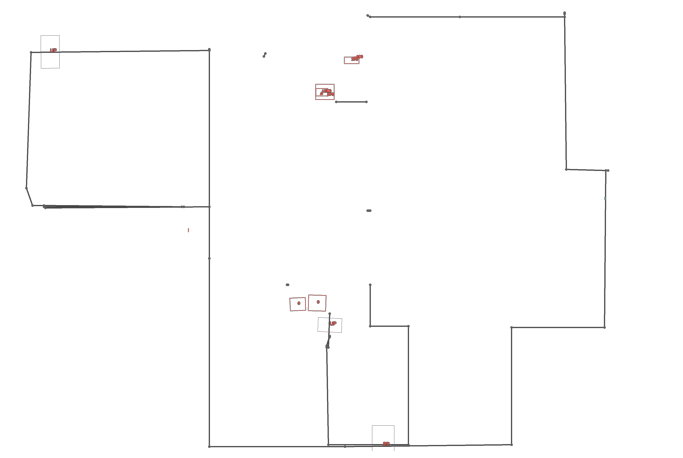

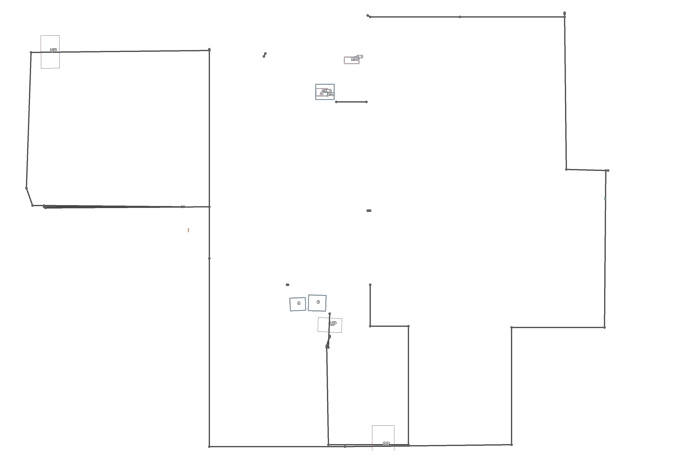

In [16]:

# alpha = 0.65

fontcolors = {'green': (95, 167, 119, 255), 'red': (255, 105, 98, 255), 'white': (255,255,255, 255)}

for cname, color in fontcolors.items():
    # reconstr = np.copy(original)
    reconstr = np.full((original.shape[0], original.shape[1], 4), 0).astype(np.uint8)
    for t in ['railings', 'walls']:
        for el in res[t]:
            s, e = el['points']
            reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), colors[t][0], 3)

    # reconstr = cv2.addWeighted(reconstr, alpha, original, 1 - alpha, 0)

    for t in ['railings', 'walls']:
        for el in res[t]:
            s, e = el['points']
            reconstr = cv2.circle(reconstr, np.intp(s), 3, colors[t][1], 3)
            reconstr = cv2.circle(reconstr, np.intp(e), 3, colors[t][1], 3)

    for wall in res['walls']:
        if 'elements' in wall:
            for el in wall['elements']:
                s, e = el['points']
                if el['type'] == 'window':
                    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), window_color, 3)
                else:
                    # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                    # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (229, 178, 93), 1)
                    reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55,255), (15,157,88,255), (66,133,244,255), (186,85,211,255)), 1)

    for symbol in res['symbols']:
        if cname == 'red':
            reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, color, 2)
        else:
            reconstr = cv2.drawContours(reconstr, [np.intp(symbol['points'])], 0, symbol_colors[symbols.index(symbol['type'])], 2)

    for wall in res['walls']:
        if 'elements' in wall:
            for el in wall['elements']:
                s, e = el['points']
                if el['type'] == 'door':
                    # reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (177, 89, 40), 3)
                    # reconstr = cv2.drawContours(reconstr, [np.intp(el['bounding_box'])], 0, (255, 0, 0), 1)
                    reconstr = draw_poly(reconstr, np.intp(el['bounding_box']), ((219,68,55,255), (15,157,88,255), (66,133,244,255), (186,85,211,255)), 1)

    for symbol in res['symbols']:
        if symbol['type'] in ('toilet', 'sink'):
            centroid = np.intp(np.mean(symbol['points'], axis=0))
            reconstr = put_text(reconstr, str(symbol['orientation']), centroid, 0.5, color=color)

    for wall in res['walls']:
        centroid = np.intp(np.mean(wall['points'], axis=0))
        if 'elements' in wall:
            for el in wall['elements']:
                if el['type'] == 'door':
                    centroid = np.intp(np.mean(el['points'], axis=0))
                    orientation = el['orientation'][-2:]
                    if 'opposite' in el['orientation']: orientation = 'o' + orientation
                    reconstr = put_text(reconstr, orientation.upper(), centroid, 0.7, color=color)

    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(reconstr)
    plt.savefig(path + f'symbols-{cname}.png', bbox_inches='tight', pad_inches=0)
    plt.show()